<a href="https://colab.research.google.com/github/swafe/Masterthesis/blob/master/train_Mask_rcnn_small_tf1_soilsample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#tf_upgrade_v2 --intree Mask_RCNN --inplace --reportfile report.txt
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Load repository

Repository from github with the edited Mask R-CNN

In [2]:
import shutil
import os

#falls git existiert löschen
path_data = '/content/Masterthesis/Mask_rcnn_small_tf1_detect_samples'  #'/content/Mask_rcnn_small_tf1'
if os.path.exists(path_data):
  print('g')
  shutil.rmtree(path_data)
  #os.remove(path_data)

#!git clone https://github.com/matterport/Mask_RCNN.git
!git clone https://github.com/swafe/Masterthesis.git #Mask_rcnn_small_tf1.git

Cloning into 'Masterthesis'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 81 (delta 25), reused 64 (delta 15), pack-reused 0
Unpacking objects: 100% (81/81), done.


# # Mask_rcnn_small_tf1 

based on  Mask R-CNN - Inspect Balloon Training Data.
Inspect and visualize data loading and pre-processing code.




In [3]:

import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import importlib
import glob
import shutil
import imgaug
# Root directory of the project
ROOT_DIR = os.path.abspath("/content/Masterthesis/Mask_rcnn_small_tf1_detect_samples") #ROOT_DIR = os.path.abspath("")

# Import Mask RCNN
# sys.path.append('Mask_rcnn_small_tf1')  # To find local version of the library
sys.path.append('/content/Masterthesis/Mask_rcnn_small_tf1_detect_samples')  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%cd '/content/Masterthesis/Mask_rcnn_small_tf1_detect_samples/samples/soilsample'
# from samples.soilsample import soilsample_aug as soilsample
import soilsample_aug as soilsample
%cd

# #when changing  soilsample name change command '!python3 soilsample.py train'
# from samples.soilsample import soilsample_aug as soilsample 

%matplotlib inline 

/content/Masterthesis/Mask_rcnn_small_tf1_detect_samples/samples/soilsample
/root


Using TensorFlow backend.


In [4]:
# load data with dataset images for train, val and test
#falls git existiert löschen
path_data = '/content/data'
if os.path.exists(path_data):
  shutil.rmtree(path_data)
  #os.remove(path_data)

!git clone https://github.com/swafe/data.git

Cloning into 'data'...
remote: Enumerating objects: 1482, done.
remote: Total 1482 (delta 0), reused 0 (delta 0), pack-reused 1482
Receiving objects: 100% (1482/1482), 1.05 GiB | 50.34 MiB/s, done.
Resolving deltas: 100% (489/489), done.
Checking out files: 100% (1899/1899), done.


!!!Do not run next cell!!!! 

In [ ]:
#Connect to google drive to load weights from '.h5'-file. '.h5'file is to big to store in github#
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Upload Weights from google drive.
If no access to google drive, upload 'mask_rcnn_balloon.h5' into colab (see left toolbar) and change 
* fscr = '/content/mask_rcnn_balloon.h5'  
use 'Ctr + /' to comment/uncomment  
Link zu google drive to download weigths ('mask_rcnn_balloon.h5')   
* https://drive.google.com/drive/folders/1enjr2AhaeYLGD4CzN809yknnGfp5-Odx?usp=sharing    


In [ ]:
#copy weight .h5
#muss mask_rcnn_balloon.h5 wirklich geladen werden ???? bzw ist es besser Gewichte von letztem Trainig zu laden
fsrc = '/content/mask_rcnn_balloon.h5'
# fsrc = '/content/drive/My Drive/Colab/Weigths_train_model/mask_rcnn_balloon.h5'

fdst = '/content/Mask_rcnn_small_tf1/samples/soilsample'
shutil.copy(fsrc,fdst)



## Configurations

Configurations are defined in soilsample.py

In [ ]:
config = soilsample.SoilsampleConfig()
Soilsample_DIR = os.path.join(ROOT_DIR, "/root/data/vgg_annotation")

In [ ]:
print(Soilsample_DIR)

/content/data/vgg_annotation


## Dataset

In [ ]:
#change here: rename src_train and src_val json files 
src_train = '/root/data/vgg_annotation/img_horizontal/new_train_02/train/via_train.json'
src_val = '/root/data/vgg_annotation/img_horizontal/new_train_02/val/via_val.json'

path_train = os.path.split(src_train)[0]
dst_train =  os.path.join(path_train,'via_region_data.json')
shutil.copy(src_train, dst_train) 

path_val = os.path.split(src_val)[0]
dst_val =  os.path.join(path_val,'via_region_data.json')
shutil.copy(src_val, dst_val)

'/content/data/vgg_annotation/img_horizontal/new_train_02/val/via_region_data.json'

In [ ]:
# 1. create standard folder [train, val]
# 2. copy uploaded data (images) into this folders
from distutils.dir_util import copy_tree
#do not change paths
path_datasets = ['/root/data/vgg_annotation/datasets/soilsample/train', '/root/data/vgg_annotation/datasets/soilsample/val']
for i in path_datasets:
  if not os.path.exists(i):
    print(i)
    os.makedirs(i)
  else:
    print(i+' already exists')

toDirectory = path_datasets[0]
copy_tree(path_train, toDirectory)
    
toDirectory = path_datasets[1]
copy_tree(path_val, toDirectory)


/content/data/vgg_annotation/datasets/soilsample/train
/content/data/vgg_annotation/datasets/soilsample/val


['/content/data/vgg_annotation/datasets/soilsample/val/via_val.json',
 '/content/data/vgg_annotation/datasets/soilsample/val/Img_0048BKF 19_11.jpg',
 '/content/data/vgg_annotation/datasets/soilsample/val/Img_0055BKF 18_11.jpg',
 '/content/data/vgg_annotation/datasets/soilsample/val/Img_5258BKF 34.jpg',
 '/content/data/vgg_annotation/datasets/soilsample/val/Img_0073BKF 21_11.jpg',
 '/content/data/vgg_annotation/datasets/soilsample/val/IMG_5232BKF 36.JPG',
 '/content/data/vgg_annotation/datasets/soilsample/val/Img_0071BKF 20_11.jpg',
 '/content/data/vgg_annotation/datasets/soilsample/val/Img_0068BKF 20_11.jpg',
 '/content/data/vgg_annotation/datasets/soilsample/val/Img_0070BKF 20_11.jpg',
 '/content/data/vgg_annotation/datasets/soilsample/val/Img_5259BKF 34.jpg',
 '/content/data/vgg_annotation/datasets/soilsample/val/IMG_5233BKF 36.JPG',
 '/content/data/vgg_annotation/datasets/soilsample/val/Img_5234BKF 36.jpg',
 '/content/data/vgg_annotation/datasets/soilsample/val/Img_0054BKF 18_11.jpg

Augmentation is defined in soilsample.py


In [ ]:
# augmenation with load_image_gt from model.py (as modellib)
# use data_generator. datagenerater uses load_image_gt

# see section Datagenerator


/content


# Training

In [ ]:
path = '/content/Mask_rcnn_small_tf1/samples/soilsample'
os.chdir(path)
#https://github.com/matterport/Mask_RCNN/issues/796
#!python3 balloon.py train --dataset=/content/data/vgg_annotation/dataset/balloon --model=coco
!python3 soilsample_aug.py train --dataset=/root/data/vgg_annotation/datasets/soilsample --weights=coco
#!python3 soilsample.py train --dataset=/content/data/vgg_annotation/datasets/soilsample 
#!zip  '/content/drive/My Drive/Colab/logs.zip' '/content/Mask_rcnn_small_tf1/logs'

Using TensorFlow backend.
Weights:  coco
Dataset:  /content/data/vgg_annotation/datasets/soilsample
Logs:  /content/Mask_rcnn_small_tf1/logs

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bb

In [ ]:
cd '/content'

JS int web Inspector to update web page, otherwise standby after 90 min

In [ ]:
# var intervalId = null;
#  var varCounter = 0;
#  function ClickConnect()
#  	{
#       if(varCounter <= 6) /*18*/
#       {
#         console.log("Counter: " + varCounter);
#            varCounter++;
#            /* your code goes here */
#         console.log("Working");
#         var buttons = document.getElementsByTagName("colab-toolbar-button");
# 	for (var button of buttons) {
#   		/*if (button.getAttribute("icon") == "icons:refresh") { */
#       if (button.getAttribute("command") == "add-text") {
# 			button.click();
#     			console.log("Refresh or Text button clicked");
#   		}
# 	}
#       } else 
#       	{
# 	   console.log("clear Intervall");
#            clearInterval(intervalId);
#       	}
#  };
#  setInterval(ClickConnect, 1800000); /* = 30 min 600 000 = 10 min */

# clearInterval(null);  /*stopt setIntervall()*/

Save last Model into drive
todo save latest .h5 file

In [ ]:
#use this for single file
fdst = '/content/drive/My Drive/Colab'  
#shutil.copy(latest_file_mask_rcnn_soilsample_h5,fdst)
shutil.copy('/content/Mask_rcnn_small_tf1/logs/soilsample20200624T1109/mask_rcnn_soilsample_0013.h5',fdst)

'/content/drive/My Drive/Colab/mask_rcnn_soilsample_0013.h5'

In [ ]:
#use this for single file
fdst = '/content/drive/My Drive/Colab'  
#shutil.copy(latest_file_mask_rcnn_soilsample_h5,fdst)
shutil.copy('/content/Mask_rcnn_small_tf1/logs/soilsample20200624T1109/mask_rcnn_soilsample_0014.h5',fdst)

'/content/drive/My Drive/Colab/mask_rcnn_soilsample_0014.h5'

In [ ]:
#use this for single file
fdst = '/content/drive/My Drive/Colab'  
#shutil.copy(latest_file_mask_rcnn_soilsample_h5,fdst)
shutil.copy('/content/Mask_rcnn_small_tf1/logs/soilsample20200624T2021/mask_rcnn_soilsample_0015.h5',fdst)

'/content/drive/My Drive/Colab/mask_rcnn_soilsample_0015.h5'

In [ ]:
list_of_files = glob.glob('/content/Mask_rcnn_small_tf1/logs/soilsample20200530T0720/*') # * means all if need specific format then *.csv
print(list_of_files[2])
#latest_file_mask_rcnn_soilsample_h5 = max(list_of_files, key=os.path.getctime)
#latest_file_mask_rcnn_soilsample_h5 = (list_of_files, key=os.path.getctime)[-2:]
#latest_file_mask_rcnn_soilsample_h5

/content/Mask_rcnn_small_tf1/logs/soilsample20200530T0720/events.out.tfevents.1590823257.a3da1175ce96


In [ ]:
#!rm '/content/drive/My Drive/Colab/logs2.zip' 

In [ ]:
#use this for multible files, folders
!zip -r '/content/drive/My Drive/Colab/logs6.zip' latest_file_mask_rcnn_soilsample_h5

# Old Code




für training ist Soilsample_DIR nicht wichtig nur notwendig um dataset zu sehen. path wird in soilsample.py der train nochmal aus args.dataset genommen

In [ ]:
Soilsample_DIR = os.path.join(ROOT_DIR, '/content/data/vgg_annotation/datasets/soilsample')

In [ ]:
# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
dataset = soilsample.SoilsampleDataset()
dataset.load_soilsample(Soilsample_DIR, "val")  

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 29
Class Count: 2
  0. BG                                                
  1. soilsample                                        


## Display Samples

Load and display images and masks.

/content/data/vgg_annotation/datasets/soilsample/val/IMG_5263BKF 34.JPG


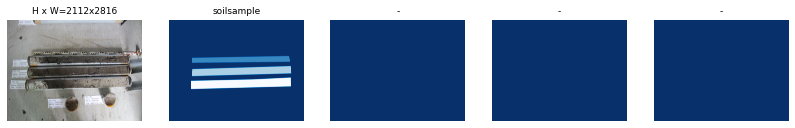

/content/data/vgg_annotation/datasets/soilsample/val/Img_5266BKF 28.jpg


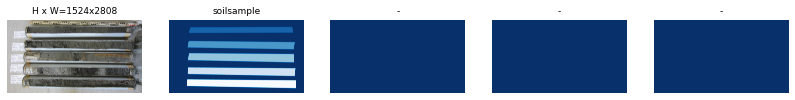

/content/data/vgg_annotation/datasets/soilsample/val/IMG_5265BKF 28.JPG


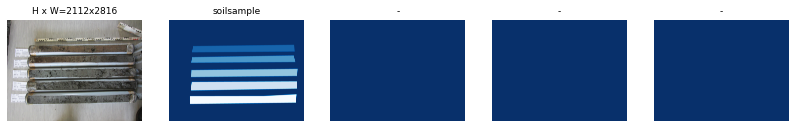

/content/data/vgg_annotation/datasets/soilsample/val/IMG_5246BKF 32.JPG


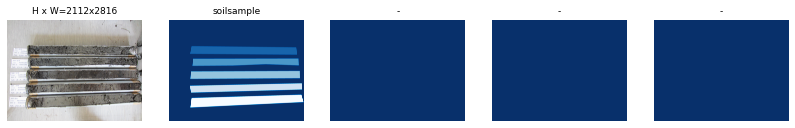

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    print(dataset.image_reference(image_id))
    image = dataset.load_image(image_id)# , plugin='pil'
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Bounding Boxes

Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation.

image_id  24 /content/data/vgg_annotation/datasets/soilsample/val/IMG_5233BKF 36.JPG
image                    shape: (2112, 2816, 3)       min:    6.00000  max:  255.00000  uint8
mask                     shape: (2112, 2816, 5)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (5,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (5, 4)                min:  491.00000  max: 2735.00000  int32


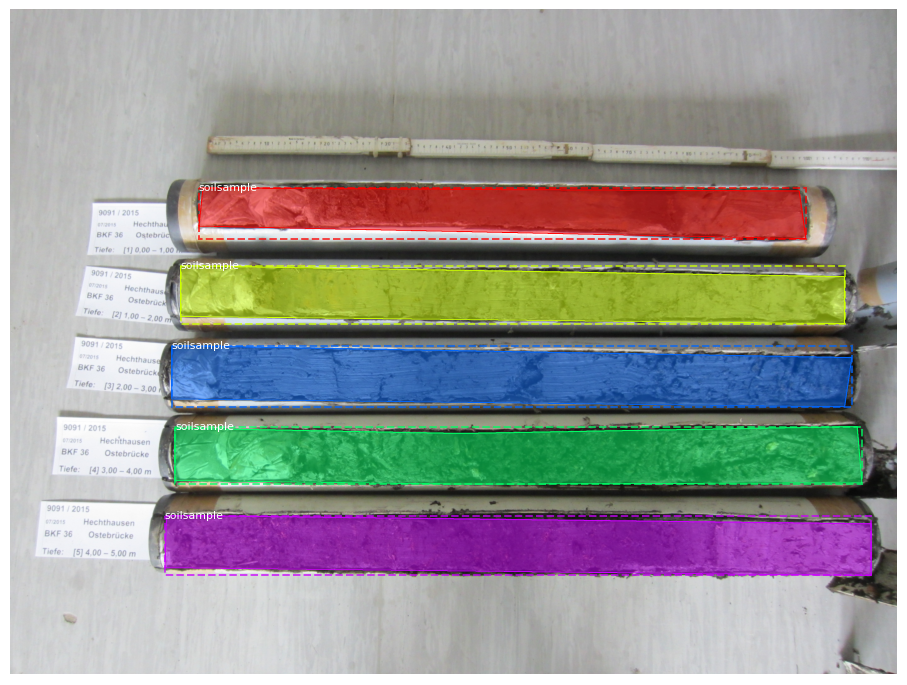

In [ ]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id) #, plugin='pil'
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Resize Images

To support multiple images per batch, images are resized to one size (1024x1024). Aspect ratio is preserved, though. If an image is not square, then zero padding is added at the top/bottom or right/left.

image_id:  6 /content/data/vgg_annotation/datasets/soilsample/val/Img_5270BKF 28.jpg
Original shape:  (1407, 2667, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 5)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (5,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (5, 4)                min:  187.00000  max: 1003.00000  int32


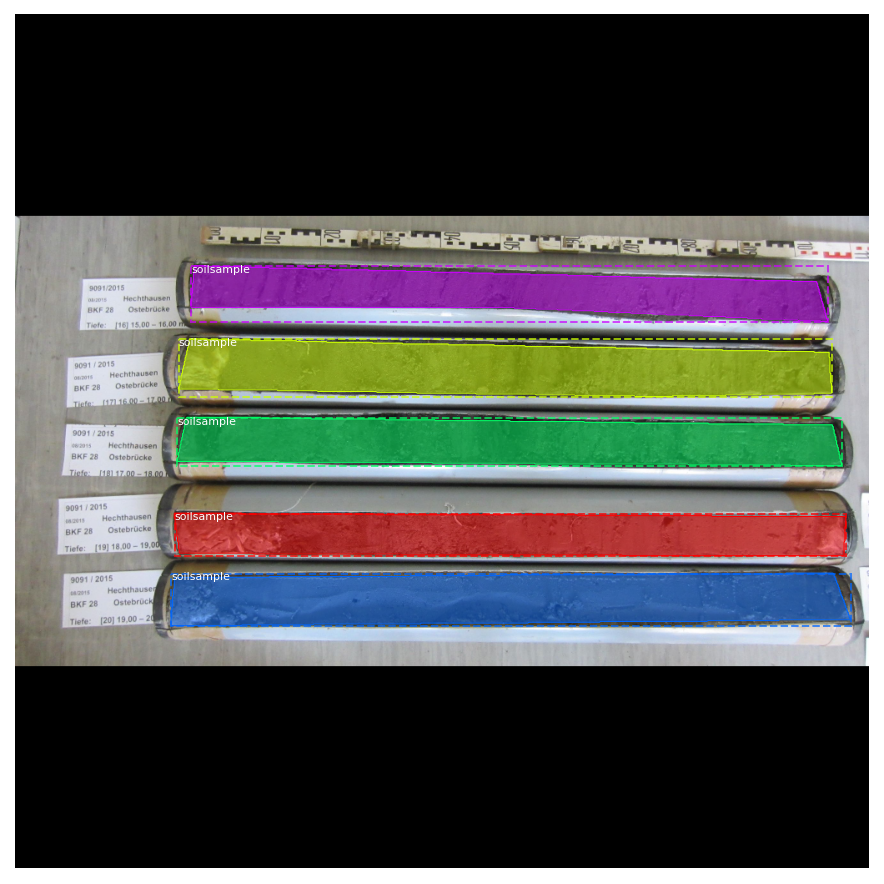

In [ ]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Mini Masks

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone. 

To improve training speed, we optimize masks by:
* We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we save space by not storing a lot of zeros around the object.
* We resize the mask to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accuracy to begin with, so this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.

To visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 2816.00000  float64
class_ids                shape: (5,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (5, 4)                min:  179.00000  max:  994.00000  int32
mask                     shape: (1024, 1024, 5)       min:    0.00000  max:    1.00000  bool


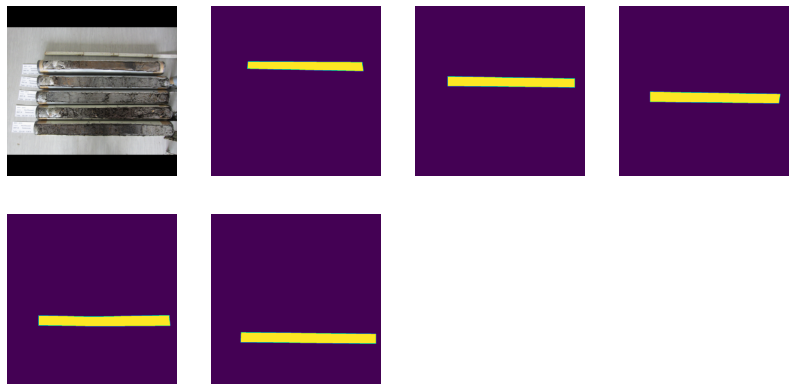

In [ ]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

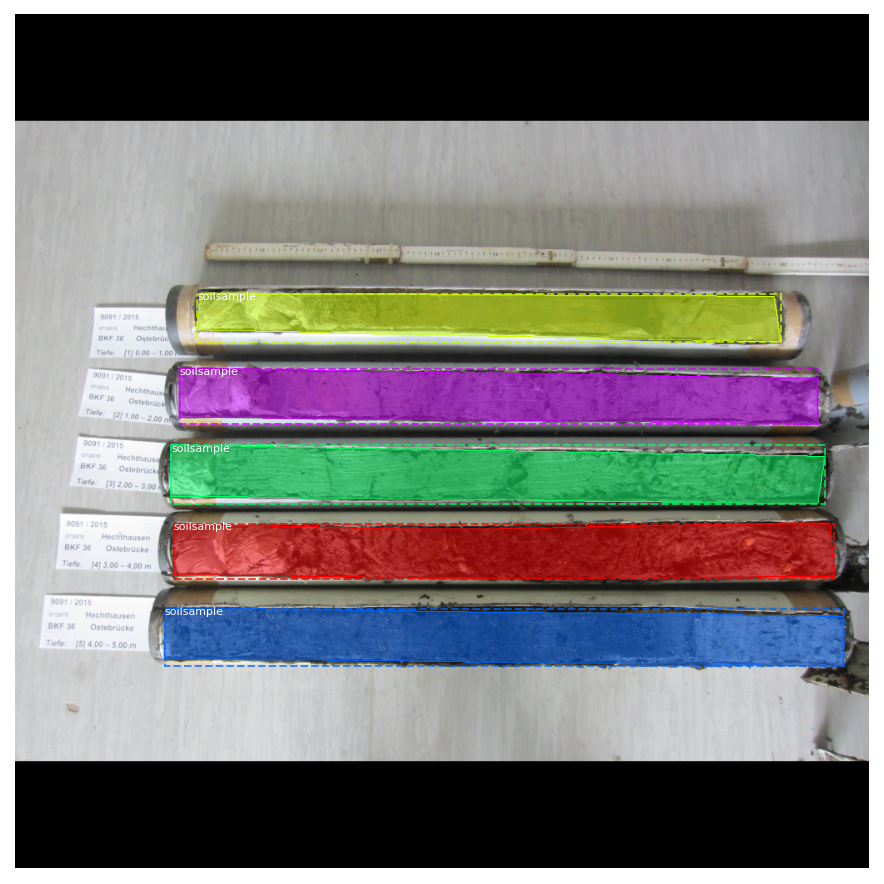

In [ ]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (56, 56, 5)           min:    0.00000  max:    1.00000  bool


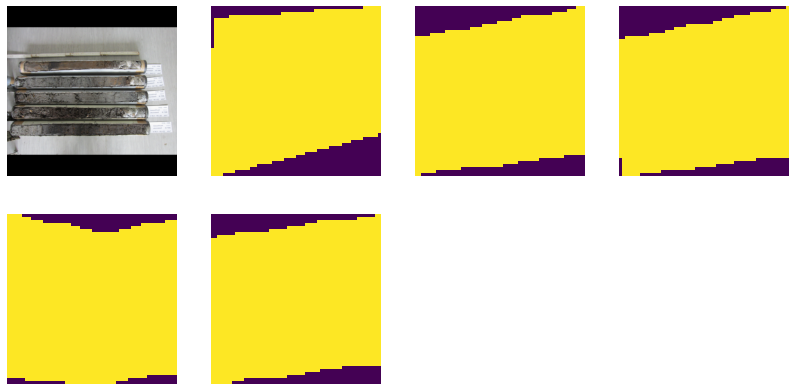

In [ ]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

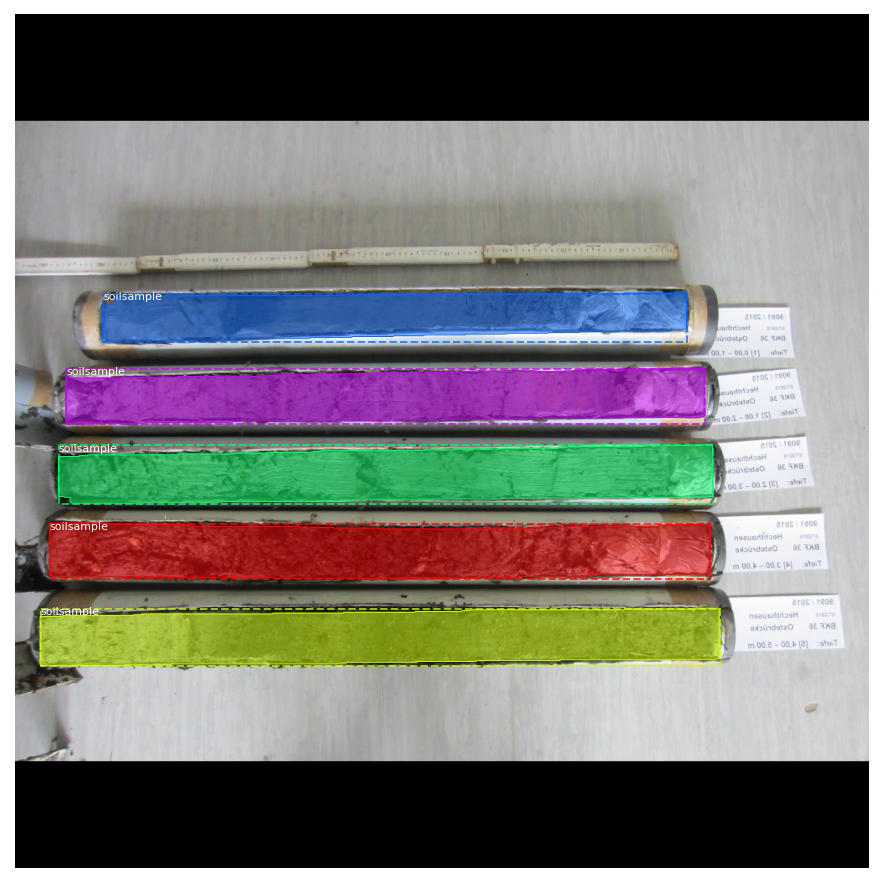

In [ ]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Anchors

The order of anchors is important. Use the same order in training and prediction phases. And it must match the order of the convolution execution.

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 
* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row. 
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

**Anchor Stride:**
In the FPN architecture, feature maps at the first few layers are high resolution. For example, if the input image is 1024x1024 then the feature meap of the first layer is 256x256, which generates about 200K anchors (256*256*3). These anchors are 32x32 pixels and their stride relative to image pixels is 4 pixels, so there is a lot of overlap. We can reduce the load significantly if we generate anchors for every other cell in the feature map. A stride of 2 will cut the number of anchors by 4, for example. 

In this implementation we use an anchor stride of 2, which is different from the paper.

In [ ]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  261888
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768


Visualize anchors of one cell at the center of the feature map of a specific level.

Level 0. Anchors: 196608  Feature map Shape: [256 256]
Level 1. Anchors:  49152  Feature map Shape: [128 128]
Level 2. Anchors:  12288  Feature map Shape: [64 64]
Level 3. Anchors:   3072  Feature map Shape: [32 32]
Level 4. Anchors:    768  Feature map Shape: [16 16]


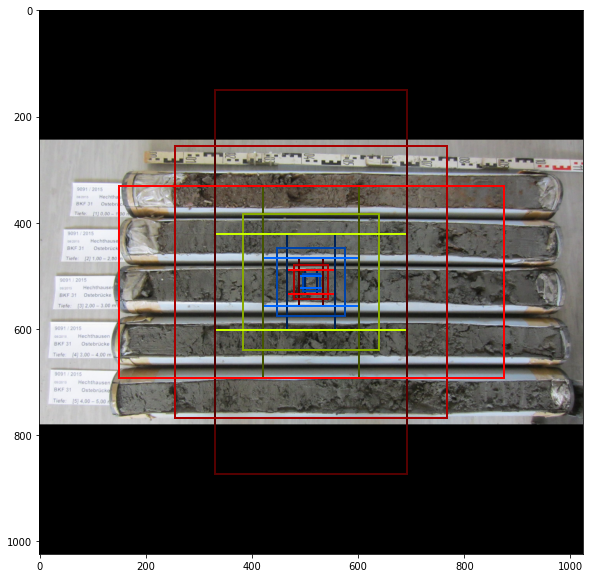

In [ ]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


## Data Generator


In [ ]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [ ]:
# Uncomment to run the generator through a lot of images
# to catch rare errors
# for i in range(1000):
#     print(i)
#     _, _ = next(g)

In [ ]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 200, 4)           min:    0.00000  max: 1023.00000  int32
mrcnn_class_ids          shape: (4, 200, 1)           min:    0.00000  max:    1.00000  int32
mrcnn_bbox               shape: (4, 200, 2, 4)        min:   -3.75746  max:    3.69099  float32
mrcnn_mask               shape: (4, 200, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 100)              min:    0.00000  max:    1.00000  int32
gt_boxes                 shape: (4, 100, 4)           min:    0.00000  max:  975.00000  int32
gt_masks                 shape: (4, 56, 56, 100)      min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 261888, 1)        min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 256, 4)           min:   -6.33389  max:    6.40816  float64
image_id:  21 /content/data/vgg_annotation/datasets/soilsample/val/IMG_5263BKF 34.JPG


anchors                  shape: (261888, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (73, 4)               min:  167.99997  max:  928.00000  float32
Positive anchors: 73
Negative anchors: 183
Neutral anchors: 261632
BG                     : 138
soilsample             : 62


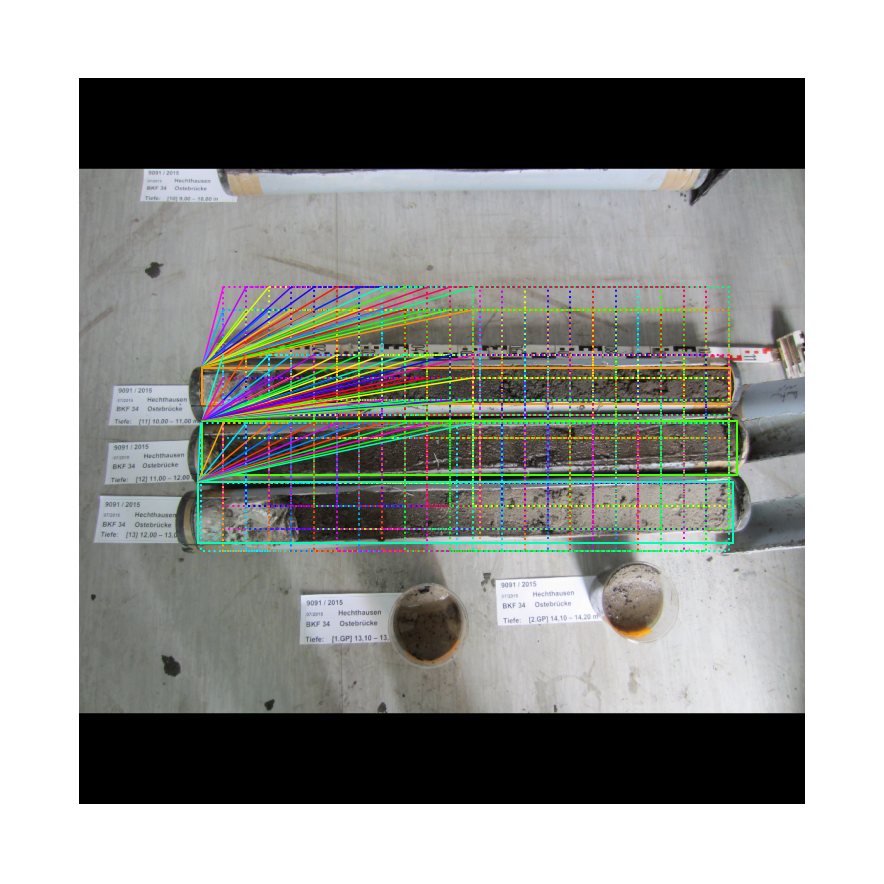

In [ ]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

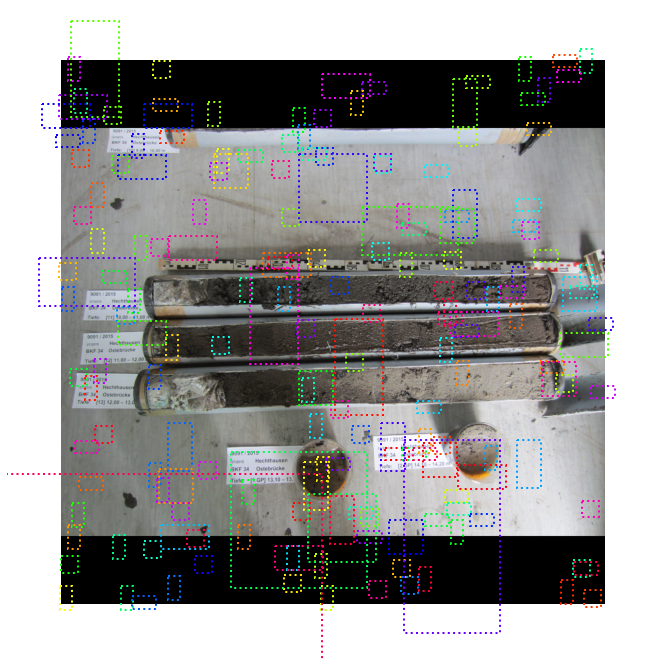

In [ ]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

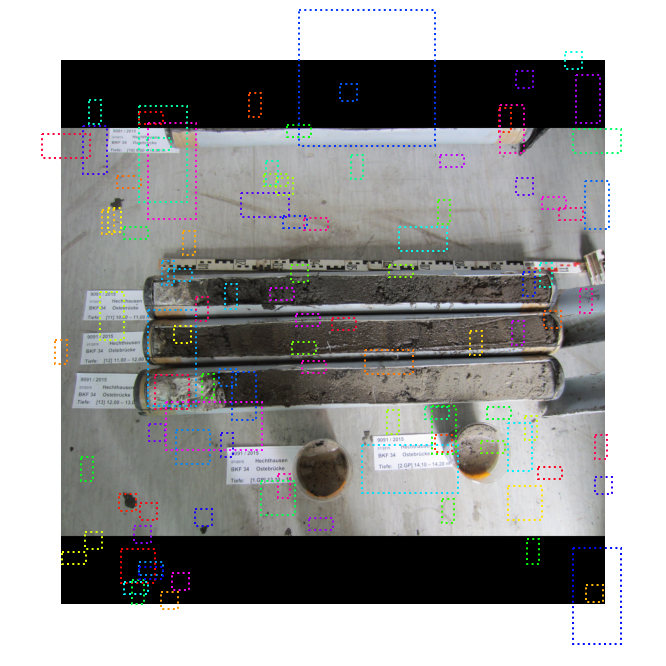

In [ ]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Positive ROIs:  62
Negative ROIs:  138
Positive Ratio: 0.31
Unique ROIs: 200 out of 200


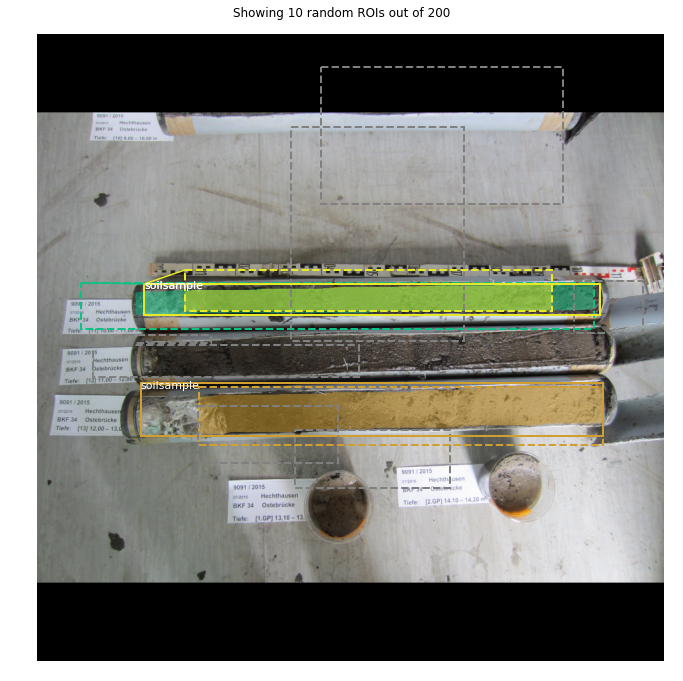

In [ ]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

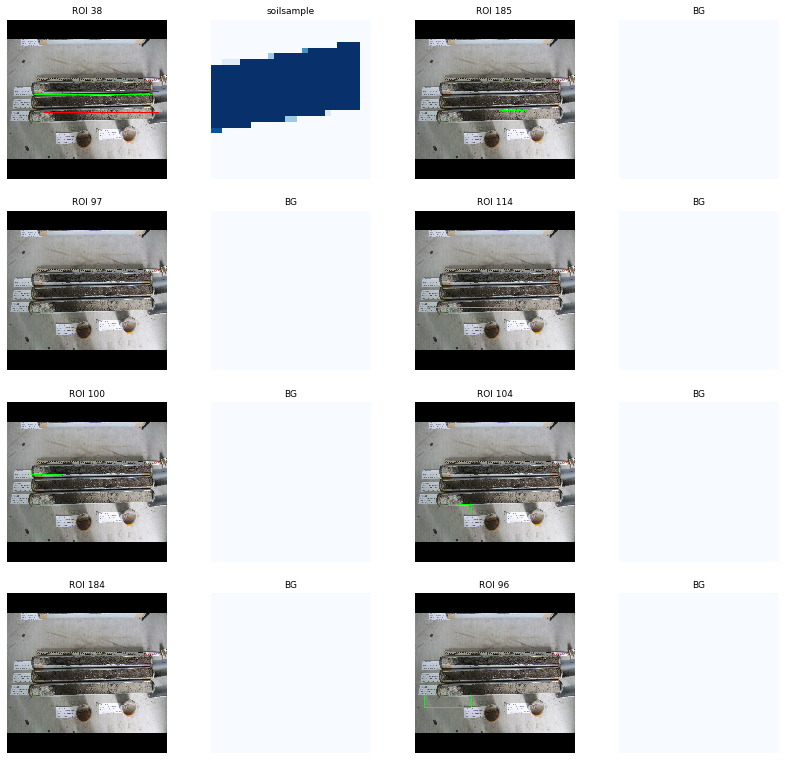

In [ ]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [ ]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
Average percent: 0.33
